In [1]:
import numpy as np
import imageio
import cv2
import matplotlib.pyplot as plt
import glob
import skimage
import scipy
from skimage.filters import (threshold_otsu, threshold_niblack,
                             threshold_sauvola)
from skimage import morphology

# Load resources

In [2]:
cards = np.array([np.array(imageio.imread(filename)) for filename in sorted(glob.glob('./cards/*.jpg'))])

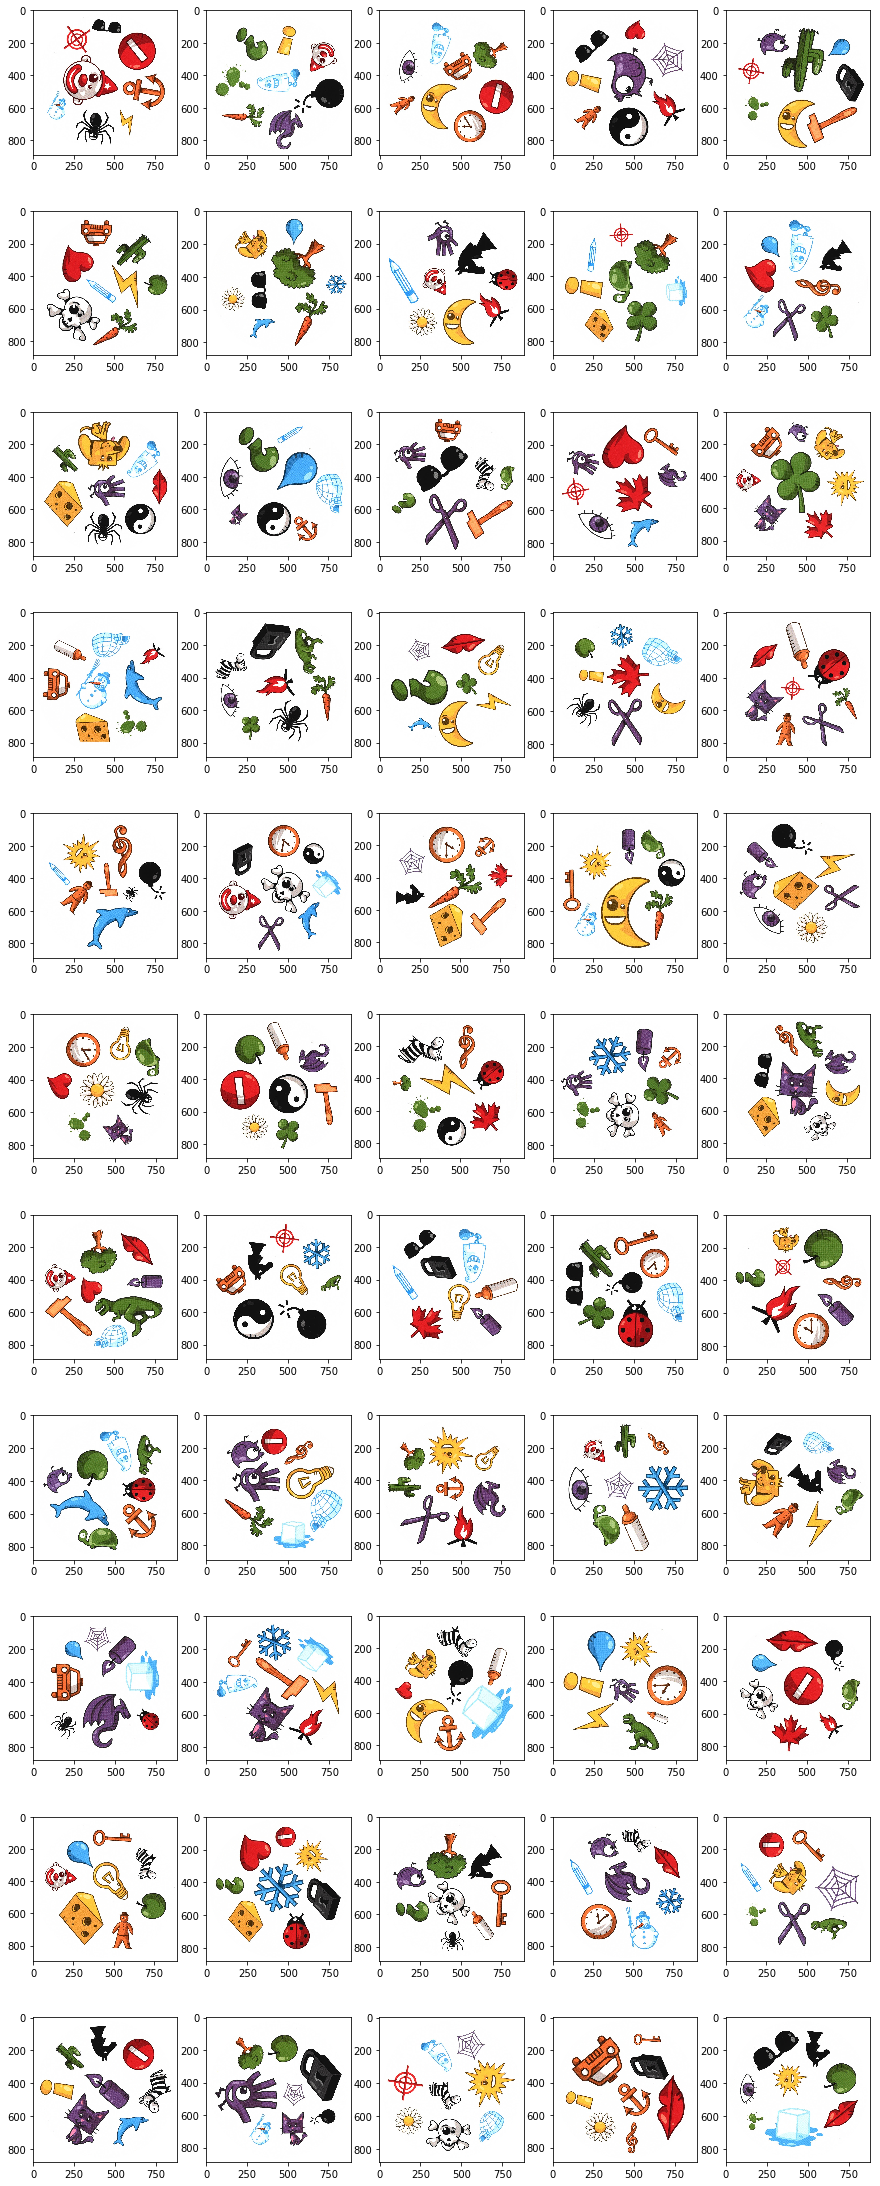

In [3]:
#print all images
fig=plt.figure(figsize=(15, 40))
for i, img in enumerate(cards):
    fig.add_subplot(11, 5, i+1)
    plt.imshow(img)
plt.show()

# Test on one card

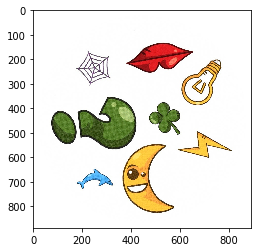

In [225]:
test_card = cards[17]
plt.imshow(test_card)

In [226]:
from skimage.filters import threshold_otsu

test_card = test_card.mean(2)

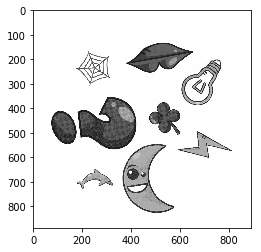

In [227]:
plt.imshow(test_card, cmap='gray')

In [228]:
test_card[test_card < 240] = 0

In [229]:
test_card = test_card == False

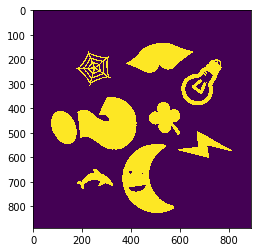

In [230]:
plt.imshow(test_card)

In [231]:
from skimage import morphology 
res = morphology.remove_small_holes(test_card, 40000)

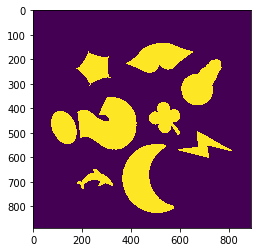

In [232]:
plt.imshow(res)

In [233]:
res = morphology.remove_small_objects(res, 90)

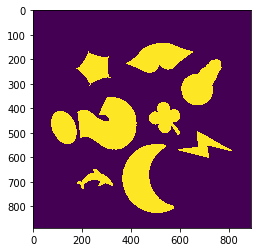

In [234]:
plt.imshow(res)

In [235]:
from skimage.measure import label

In [236]:
labels = label(res)

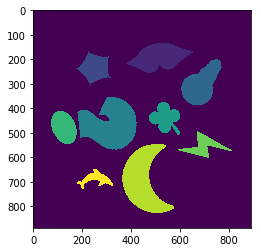

In [237]:
plt.imshow(labels)

In [238]:
#Count the number of symbols (should be 9, 8 symbols + the background)

print(len(np.unique(labels)))

10


In [239]:
# if more than 9
if (len(np.unique(labels)) > 9):
    selem = morphology.diamond(2)
    dilated = morphology.dilation(res, selem)
    labels = label(dilated)
    while len(np.unique(labels)) > 9:
        dilated = morphology.dilation(dilated, selem)
        labels = label(dilated)
        print(len(np.unique(labels)))

labels[res == 0] = 0


10
9


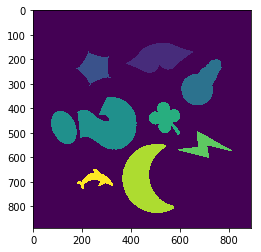

In [240]:
plt.imshow(labels)

# Test on all images

In [243]:
def get_symbols(img):
    img = img.mean(2)
    img[img < 240] = 0
    img = img == False
    res = morphology.remove_small_holes(img, 40000)
    res = morphology.remove_small_objects(res, 300)
    labels = label(res)
    if (len(np.unique(labels)) > 9):
        selem = morphology.diamond(2)
        dilated = morphology.dilation(res, selem)
        labels = label(dilated)
        while len(np.unique(labels)) > 9:
            dilated = morphology.dilation(dilated, selem)
            labels = label(dilated)
    labels[res == 0] = 0
    return labels
    

In [ ]:
fig=plt.figure(figsize=(15, 40))
for i, card in enumerate(cards):
    symbols = get_symbols(card)
    fig.add_subplot(11, 5, i+1)
    title = "Card: " + str(i)
    if len(np.unique(symbols)) == 9:
        title += ": OK"
        plt.title(title)
    else:
        title += ": KO"
        title_obj = plt.title(title)
        plt.setp(title_obj, color='r')
    plt.imshow(symbols)
plt.show()
